In [139]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon, Patch
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import json

In [140]:
def _plot_sensors(
  ax, sensors, marker, clr, label,
  sens_area_radius=None, sens_area_alpha=0.3):

  if len(sensors) == 0:
    return None

  xy = [[s['x'], s['y']] for s in sensors]
  if sens_area_radius is not None:
    patches = []
    for i in range(len(xy)):
      circle = Circle(
        xy=(xy[i][0], xy[i][1]), 
        radius=sens_area_radius)
      patches.append(circle)
    ax.add_collection(PatchCollection(
      patches, alpha=sens_area_alpha, 
      facecolor=clr, edgecolor=clr,
    ))

  xy = np.array(xy).T
  ax.scatter(xy[0], xy[1], marker=marker, facecolor=clr)

  # legend
  return Line2D(
    [0], [0], lw=0, marker=marker, 
    mfc=clr, mec=clr, label=label)


def plot_sensors(
  ax, sensors, 
  marker={'Sensing': 'none', 'Sleep': 'none'}, 
  clr={'Sensing': 'none', 'Sleep': 'none'}, 
  sens_area_radius=None, sens_area_alpha=0.3):

  legends = []
  for mode in ['Sleep', 'Sensing']:
    legend = _plot_sensors(ax, 
      list(filter(lambda s: s['mode'] == mode, sensors)),
      marker[mode], clr[mode], 'Sensor Node ({})'.format(mode),
      sens_area_radius if mode == 'Sensing' else None,
      sens_area_alpha)
    legends.append(legend)
  
  # legend for sensing areas
  if sens_area_radius is not None and \
    any(s['mode'] == 'Sensing' for s in sensors):

    clr = clr['Sensing']
    legends.append(Line2D(
      [0], [0], lw=0, 
      marker='o', 
      markersize=20,
      mfc=clr, mec=clr, 
      alpha=sens_area_alpha,
      label='Sensing Area (r={:.1f} [m])'.format(sens_area_radius)
    )) 

  return legends

In [141]:
def plot_bases(ax, bases, marker, marker_clr):
  return [_plot_sensors(ax, bases, marker, marker_clr, label='Base Node')]

In [142]:
def plot_obstacles(ax, obstacles, 
  face_clr={'Hollow': 'none', 'Solid': 'none'}, 
  edge_clr={'Hollow': 'none', 'Solid': 'none'}):
  for obs in obstacles:
    poly = Polygon(obs['shape'], closed=True, 
      fc=face_clr[obs['kind']], 
      ec=edge_clr[obs['kind']])
    ax.add_patch(poly)
  
  legends = []
  if any(obs['kind'] == 'Hollow' for obs in obstacles):
    legends.append(Patch(
      facecolor=face_clr['Hollow'], label='Hollow Obstacle'
    ))
  
  if any(obs['kind'] == 'Solid' for obs in obstacles):
    legends.append(Patch(
      facecolor=face_clr['Solid'], label='Solid Obstacle'
    ))
  
  return legends

In [143]:
def plot_snapshot(ax, snapshot):
  bases = list(snapshot['base_nodes'].values())
  mobile_sensors = list(snapshot['mobile_sensor_nodes'].values())
  static_sensors = list(snapshot['static_sensor_nodes'].values())
  obstacles = snapshot['obstacles']

  legends = [
    plot_obstacles(ax, obstacles, 
      face_clr={'Hollow': 'green', 'Solid': 'blue'}),
    
    plot_sensors(ax, mobile_sensors, 
      clr={'Sleep': 'grey', 'Sensing': 'red'}, 
      marker={'Sleep': 'x', 'Sensing': 'o'}, 
      sens_area_radius=20, sens_area_alpha=0.1),

    plot_sensors(ax, static_sensors, 
      clr={'Sleep': 'blue', 'Sensing': 'cyan'}, 
      marker={'Sleep': 'x', 'Sensing': 'o'}, 
      sens_area_radius=20, sens_area_alpha=0.1),
    
    plot_bases(ax, bases, marker='^', marker_clr='blue'),
  ]

  return [
    le for item in legends if item != None
      for le in item if le != None
  ] 


In [144]:
def snapshot2fig(snapshot, figsize, font_size=None):
  if font_size is None:
    font_size = {
      'axis': 18,
      'legend': 18,
      'ticks': 18,
    }
  elif type(font_size) is int:
    font_size = {
      'axis': font_size,
      'legend': font_size,
      'ticks': font_size,
    }

  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)

  legends = plot_snapshot(ax, snapshot)

  fig.legend(
    handles=legends, bbox_to_anchor=(0.5, 0.9),
    loc='lower center', 
    ncol=3,
    # ncol=len(legends),
    prop={'size': font_size['legend']})

  fig.text(0.5, 0.04, 'x [m]', ha='center', 
    fontsize=font_size['axis'])

  fig.text(0.02, 0.5, 'y [m]', va='center', 
    rotation='vertical', fontsize=font_size['axis'])
  
  ax.tick_params(axis='both', labelsize=font_size['ticks'])

  # xy-axis labels
  field = snapshot['field']
  ax.set_xlim([field[0], field[2]])
  ax.set_ylim([field[1], field[3]])

  # plt.grid()

  return (ax, fig)

(<AxesSubplot:>, <Figure size 720x720 with 1 Axes>)

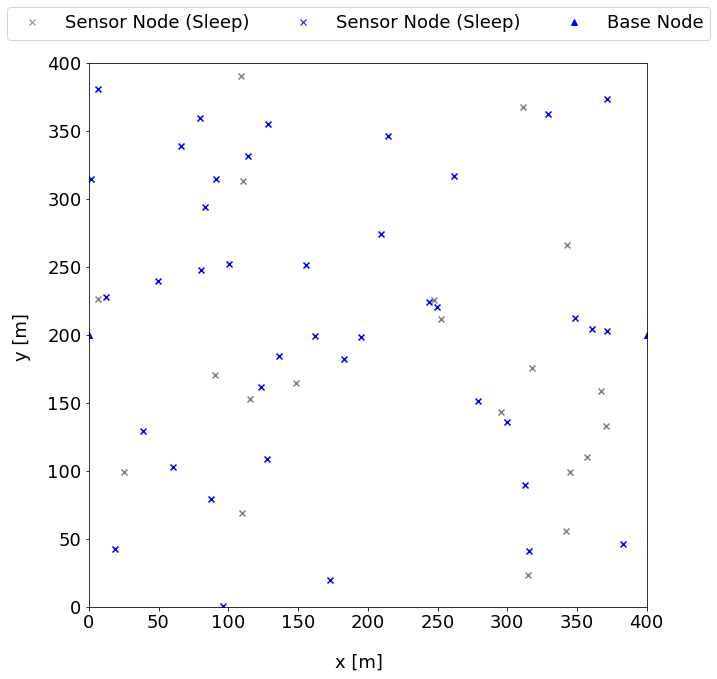

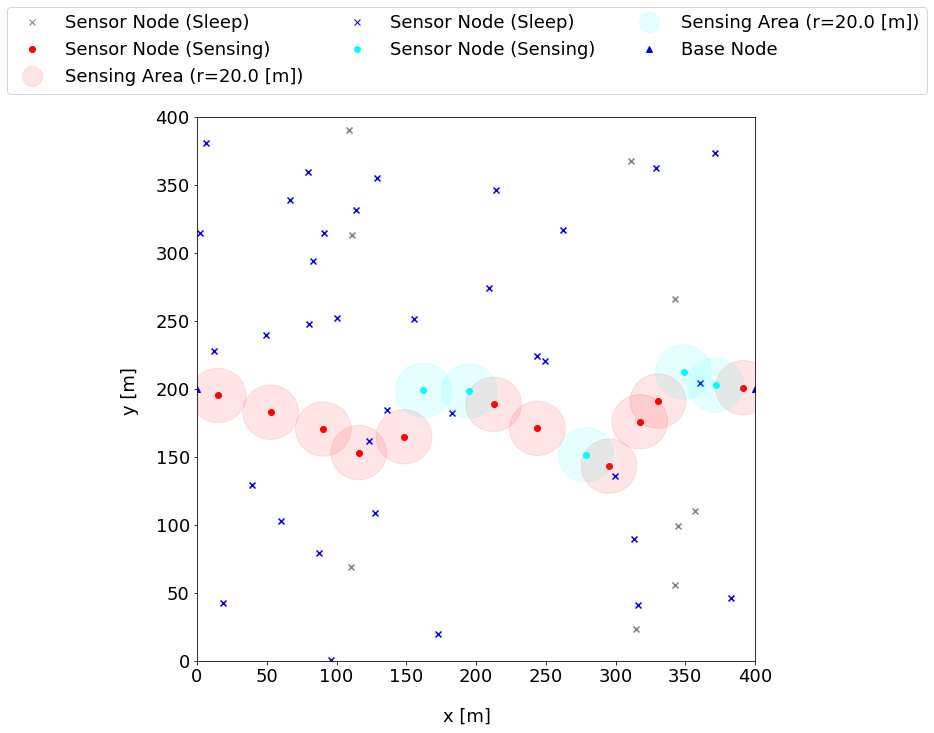

In [145]:
snapshot_file_path = '../tmp/tmp-multi-u/simulation_result.json'
with open(snapshot_file_path, 'r') as f:
  snapshot = json.load(f)
snapshot2fig(snapshot[0]['before'], figsize=(10, 10))
snapshot2fig(snapshot[0]['after'], figsize=(10, 10))